In [1]:
import sys
# Find jVMC package
sys.path.append(sys.path[0] + "/..")

import jax
from jax.config import config
config.update("jax_enable_x64", True)

import jax.random as random
import jax.numpy as jnp
import flax.linen as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/tmp/ipykernel_25295/3294815756.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# install the pip package and import jVMC
#!pip install jVMC

import jVMC

In [3]:
L = 10
g = -0.7

GPU_avail = False
# Initialize net
if GPU_avail:
  # reproduces results in Fig. 3 of the paper
  # estimated run_time in colab (GPU enabled): ~26 minutes
  net = jVMC.nets.CNN(F=(L,), channels=(16,), strides=(1,), periodicBoundary=True)
  n_steps = 1000
  n_Samples = 40000
else:
  # may be used to obtain results on Laptop CPUs
  # estimated run_time: ~100 seconds
  net = jVMC.nets.CpxRBM(numHidden=8, bias=False)
  n_steps = 300
  n_Samples = 5000

psi = jVMC.vqs.NQS(net, seed=1234)  # Variational wave function

In [4]:
def energy_single_p_mode(h_t, P):
    return np.sqrt(1 + h_t**2 - 2 * h_t * np.cos(P))

def ground_state_energy_per_site(h_t, N):
    Ps =  0.5 * np.arange(- (N - 1), N - 1 + 2, 2)
    Ps = Ps * 2 * np.pi / N
    energies_p_modes =  np.array([energy_single_p_mode(h_t, P) for P in Ps])
    return - 1 / N * np.sum(energies_p_modes)

exact_energy = ground_state_energy_per_site(g, L)
print(exact_energy)

-1.127222500154964


In [5]:
# Set up hamiltonian
hamiltonian = jVMC.operator.BranchFreeOperator()
for l in range(L):
    hamiltonian.add(jVMC.operator.scal_opstr(-1., (jVMC.operator.Sz(l), jVMC.operator.Sz((l + 1) % L))))
    hamiltonian.add(jVMC.operator.scal_opstr(g, (jVMC.operator.Sx(l), )))

In [6]:
# Set up sampler
sampler = jVMC.sampler.MCSampler(psi, (L,), random.PRNGKey(4321), updateProposer=jVMC.sampler.propose_spin_flip_Z2,
                                 numChains=100, sweepSteps=L,
                                 numSamples=n_Samples, thermalizationSweeps=25)

# Set up TDVP
tdvpEquation = jVMC.util.tdvp.TDVP(sampler, rhsPrefactor=1.,
                                   pinvTol=1e-8, diagonalShift=10, makeReal='real')

stepper = jVMC.util.stepper.Euler(timeStep=1e-2)  # ODE integrator

In [7]:
sampler.net.is_gumbel

False

In [8]:
res = []
for n in tqdm(range(n_steps)):

    dp, _ = stepper.step(0, tdvpEquation, psi.get_parameters(), hamiltonian=hamiltonian, psi=psi, numSamples=None)
    psi.set_parameters(dp)

    print(n, jax.numpy.real(tdvpEquation.ElocMean0) / L, tdvpEquation.ElocVar0 / L)

    res.append([n, jax.numpy.real(tdvpEquation.ElocMean0) / L, tdvpEquation.ElocVar0 / L])

  0%|▏                                                                   | 1/300 [00:05<29:34,  5.93s/it]

0 -0.705276783417889 5.955611729739241


  1%|▍                                                                   | 2/300 [00:06<13:08,  2.65s/it]

1 -0.7081642757418638 6.01450073880253


  1%|▋                                                                   | 3/300 [00:06<07:57,  1.61s/it]

2 -0.7246028998553427 6.234450161191679


  1%|▉                                                                   | 4/300 [00:06<05:21,  1.09s/it]

3 -0.729981860901069 6.330946567901932


  2%|█▏                                                                  | 5/300 [00:07<03:57,  1.24it/s]

4 -0.7297194766115246 6.276517480370748


  2%|█▎                                                                  | 6/300 [00:07<03:06,  1.58it/s]

5 -0.7428473282012106 6.4671241841196645


  2%|█▌                                                                  | 7/300 [00:07<02:33,  1.91it/s]

6 -0.7563274824071944 6.665690218784009


  3%|█▊                                                                  | 8/300 [00:08<02:13,  2.18it/s]

7 -0.7830521551238949 7.072728200913086


  3%|██                                                                  | 9/300 [00:08<01:59,  2.43it/s]

8 -0.7837336719025413 7.070248848913979


  3%|██▏                                                                | 10/300 [00:08<01:49,  2.65it/s]

9 -0.7989197385698203 7.322301332945313


  4%|██▍                                                                | 11/300 [00:09<01:46,  2.72it/s]

10 -0.815080520457597 7.549064809170939


  4%|██▋                                                                | 12/300 [00:09<01:42,  2.80it/s]

11 -0.8329817303583255 7.881536777103207


  4%|██▉                                                                | 13/300 [00:09<01:37,  2.94it/s]

12 -0.8514487462603955 8.168614472060417


  5%|███▏                                                               | 14/300 [00:10<01:39,  2.88it/s]

13 -0.8612481914706878 8.308909648339347


  5%|███▎                                                               | 15/300 [00:10<01:37,  2.92it/s]

14 -0.8816324113925736 8.6381931099004


  5%|███▌                                                               | 16/300 [00:10<01:37,  2.92it/s]

15 -0.9023722831463568 8.99179823693622


  6%|███▊                                                               | 17/300 [00:11<01:35,  2.97it/s]

16 -0.9124651923546321 9.17173378405418


  6%|████                                                               | 18/300 [00:11<01:34,  2.99it/s]

17 -0.92442450783159 9.350745651778078


  6%|████▏                                                              | 19/300 [00:11<01:32,  3.03it/s]

18 -0.9343887038259424 9.522127579971743


  7%|████▍                                                              | 20/300 [00:12<01:29,  3.12it/s]

19 -0.9721992995367815 10.189199915015703


  7%|████▋                                                              | 21/300 [00:12<01:28,  3.15it/s]

20 -0.9954908013031 10.556656213979162


  7%|████▉                                                              | 22/300 [00:12<01:29,  3.10it/s]

21 -1.0029664270906706 10.674431061942185


  8%|█████▏                                                             | 23/300 [00:13<01:30,  3.06it/s]

22 -1.01723546638922 10.93407978049074


  8%|█████▎                                                             | 24/300 [00:13<01:27,  3.14it/s]

23 -1.0256534297797175 11.053827043835877


  8%|█████▌                                                             | 25/300 [00:13<01:28,  3.12it/s]

24 -1.0422828764493137 11.330865572252169


  9%|█████▊                                                             | 26/300 [00:13<01:27,  3.13it/s]

25 -1.04491709691533 11.383587426661492


  9%|██████                                                             | 27/300 [00:14<01:26,  3.16it/s]

26 -1.0535468973934212 11.513024501969607


  9%|██████▎                                                            | 28/300 [00:14<01:27,  3.10it/s]

27 -1.05940503907021 11.609268986283144


 10%|██████▍                                                            | 29/300 [00:14<01:26,  3.13it/s]

28 -1.0631497907486271 11.63709266955389


 10%|██████▋                                                            | 30/300 [00:15<01:27,  3.08it/s]

29 -1.07096429481446 11.802207902481877


 10%|██████▉                                                            | 31/300 [00:15<01:28,  3.03it/s]

30 -1.073708259851172 11.829965521774099


 11%|███████▏                                                           | 32/300 [00:15<01:25,  3.13it/s]

31 -1.0695360403647562 11.768244184539586


 11%|███████▎                                                           | 33/300 [00:16<01:23,  3.19it/s]

32 -1.076974954742986 11.863788364582357


 11%|███████▌                                                           | 34/300 [00:16<01:22,  3.22it/s]

33 -1.0708186367544177 11.787600554083697


 12%|███████▊                                                           | 35/300 [00:16<01:21,  3.24it/s]

34 -1.067128432028845 11.664332859270033


 12%|████████                                                           | 36/300 [00:17<01:22,  3.19it/s]

35 -1.0659112920801381 11.618538943788625


 12%|████████▎                                                          | 37/300 [00:17<01:21,  3.22it/s]

36 -1.0711824547458257 11.798874639529995


 13%|████████▍                                                          | 38/300 [00:17<01:21,  3.22it/s]

37 -1.0674635596745092 11.709969155332198


 13%|████████▋                                                          | 39/300 [00:18<01:23,  3.12it/s]

38 -1.0673736805258116 11.750937157939964


 13%|████████▉                                                          | 40/300 [00:18<01:21,  3.19it/s]

39 -1.0576301500717364 11.479434916449474


 14%|█████████▏                                                         | 41/300 [00:18<01:20,  3.20it/s]

40 -1.0622261422395212 11.591880288133705


 14%|█████████▍                                                         | 42/300 [00:19<01:23,  3.10it/s]

41 -1.055840671680817 11.421261789500772


 14%|█████████▌                                                         | 43/300 [00:19<01:26,  2.95it/s]

42 -1.0530546335839648 11.38103711710311


 15%|█████████▊                                                         | 44/300 [00:19<01:30,  2.84it/s]

43 -1.0517171626441109 11.349008784714695


 15%|██████████                                                         | 45/300 [00:20<01:28,  2.88it/s]

44 -1.0499869419536294 11.331929412226966


 15%|██████████▎                                                        | 46/300 [00:20<01:36,  2.64it/s]

45 -1.0462317020398493 11.25279596839464


 16%|██████████▍                                                        | 47/300 [00:20<01:36,  2.63it/s]

46 -1.048891127752699 11.416734200551206


 16%|██████████▋                                                        | 48/300 [00:21<01:38,  2.55it/s]

47 -1.0482630112573295 11.417622182395224


 16%|██████████▉                                                        | 49/300 [00:21<01:40,  2.50it/s]

48 -1.0435798830544933 11.232588159898086


 17%|███████████▏                                                       | 50/300 [00:22<01:38,  2.53it/s]

49 -1.0350049593133224 10.97374012437707


 17%|███████████▍                                                       | 51/300 [00:22<01:36,  2.58it/s]

50 -1.0372093682161703 11.100264522580506


 17%|███████████▌                                                       | 52/300 [00:22<01:38,  2.52it/s]

51 -1.0360513712460673 11.131403079690354


 18%|███████████▊                                                       | 53/300 [00:23<01:36,  2.55it/s]

52 -1.0390915855581333 11.357589088166472


 18%|████████████                                                       | 54/300 [00:23<01:34,  2.59it/s]

53 -1.0308431658522756 10.97926473139128


 18%|████████████▎                                                      | 55/300 [00:24<01:36,  2.54it/s]

54 -1.0310738934867774 11.047109276089543


 19%|████████████▌                                                      | 56/300 [00:24<01:35,  2.57it/s]

55 -1.0250389686069492 10.755964421618183


 19%|████████████▋                                                      | 57/300 [00:24<01:35,  2.54it/s]

56 -1.032159488065138 11.25363769603293


 19%|████████████▉                                                      | 58/300 [00:25<01:35,  2.53it/s]

57 -1.024626124072611 10.80290387883125


 20%|█████████████▏                                                     | 59/300 [00:25<01:32,  2.60it/s]

58 -1.024952969634315 10.923025060516348


 20%|█████████████▍                                                     | 60/300 [00:26<01:31,  2.62it/s]

59 -1.0266280012342968 11.002349730034087


 20%|█████████████▌                                                     | 61/300 [00:26<01:32,  2.58it/s]

60 -1.0278058340700922 11.389527274262555


 21%|█████████████▊                                                     | 62/300 [00:26<01:30,  2.63it/s]

61 -1.023532386657625 10.945951081972083


 21%|██████████████                                                     | 63/300 [00:27<01:28,  2.67it/s]

62 -1.0201894209817624 10.850124766756585


 21%|██████████████▎                                                    | 64/300 [00:27<01:31,  2.59it/s]

63 -1.015207808967604 10.58708430159768


 22%|██████████████▌                                                    | 65/300 [00:28<01:30,  2.60it/s]

64 -1.015818307545886 10.612316341996243


 22%|██████████████▋                                                    | 66/300 [00:28<01:28,  2.65it/s]

65 -1.018861563735522 10.949729266797759


 22%|██████████████▉                                                    | 67/300 [00:28<01:28,  2.64it/s]

66 -1.0149009905761115 10.724761580253068


 23%|███████████████▏                                                   | 68/300 [00:29<01:28,  2.62it/s]

67 -1.0215457904855987 11.304485939788936


 23%|███████████████▍                                                   | 69/300 [00:29<01:26,  2.67it/s]

68 -1.0120780517744372 10.54240796497211


 23%|███████████████▋                                                   | 70/300 [00:29<01:26,  2.67it/s]

69 -1.017294729192039 11.055065571009864


 24%|███████████████▊                                                   | 71/300 [00:30<01:27,  2.60it/s]

70 -1.0156137719854919 10.901730103442684


 24%|████████████████                                                   | 72/300 [00:30<01:25,  2.67it/s]

71 -1.0238178194112755 12.18810063900435


 24%|████████████████▎                                                  | 73/300 [00:30<01:24,  2.70it/s]

72 -1.0068510071177468 10.227865478106972


 25%|████████████████▌                                                  | 74/300 [00:31<01:23,  2.70it/s]

73 -1.008633405717807 10.530576056482705


 25%|████████████████▊                                                  | 75/300 [00:31<01:24,  2.66it/s]

74 -1.0062443613936805 10.218532840956914


 25%|████████████████▉                                                  | 76/300 [00:32<01:23,  2.68it/s]

75 -1.0089112737363364 10.704175489552046


 26%|█████████████████▏                                                 | 77/300 [00:32<01:24,  2.63it/s]

76 -1.0085462504624259 10.689372168701894


 26%|█████████████████▍                                                 | 78/300 [00:32<01:24,  2.62it/s]

77 -1.0080023913823841 10.568941088572425


 26%|█████████████████▋                                                 | 79/300 [00:33<01:23,  2.65it/s]

78 -1.0067705473389439 10.613869258949556


 27%|█████████████████▊                                                 | 80/300 [00:33<01:22,  2.66it/s]

79 -1.0036626198503265 10.073403629288535


 27%|██████████████████                                                 | 81/300 [00:34<01:26,  2.54it/s]

80 -1.009767061982917 10.788389769979862


 27%|██████████████████▎                                                | 82/300 [00:34<01:23,  2.60it/s]

81 -1.013364090027754 11.411226549329053


 28%|██████████████████▌                                                | 83/300 [00:34<01:22,  2.62it/s]

82 -1.0030542186152391 10.061189626001491


 28%|██████████████████▊                                                | 84/300 [00:35<01:23,  2.59it/s]

83 -1.0056808451687809 10.542521117134118


 28%|██████████████████▉                                                | 85/300 [00:35<01:22,  2.61it/s]

84 -1.002705642856477 10.054195500269206


 29%|███████████████████▏                                               | 86/300 [00:35<01:20,  2.64it/s]

85 -1.007375268275413 11.469359580119654


 29%|███████████████████▍                                               | 87/300 [00:36<01:20,  2.66it/s]

86 -1.002396230963871 10.047989476271315


 29%|███████████████████▋                                               | 88/300 [00:36<01:20,  2.64it/s]

87 -1.0022549842109145 10.045157135263532


 30%|███████████████████▉                                               | 89/300 [00:37<01:19,  2.64it/s]

88 -1.0021219470620348 10.04248982642235


 30%|████████████████████                                               | 90/300 [00:37<01:19,  2.65it/s]

89 -1.0141929614890968 12.979721982934501


 30%|████████████████████▎                                              | 91/300 [00:37<01:16,  2.72it/s]

90 -1.0018781427894523 10.037602742033545


 31%|████████████████████▌                                              | 92/300 [00:38<01:19,  2.62it/s]

91 -1.006367343268869 11.27744659976078


 31%|████████████████████▊                                              | 93/300 [00:38<01:18,  2.65it/s]

92 -1.001662270422959 10.033276669168519


 31%|████████████████████▉                                              | 94/300 [00:38<01:18,  2.64it/s]

93 -1.0061462222440833 11.3002843742144


 32%|█████████████████████▏                                             | 95/300 [00:39<01:18,  2.62it/s]

94 -1.013561924069502 13.042348079983304


 32%|█████████████████████▍                                             | 96/300 [00:39<01:16,  2.66it/s]

95 -1.0013831994513116 10.027685652881896


 32%|█████████████████████▋                                             | 97/300 [00:40<01:16,  2.67it/s]

96 -1.0013010375183922 10.02603992182543


 33%|█████████████████████▉                                             | 98/300 [00:40<01:15,  2.67it/s]

97 -1.001223692310816 10.024490810243284


 33%|██████████████████████                                             | 99/300 [00:40<01:15,  2.67it/s]

98 -1.0204800218158998 21.208019303296396


 33%|██████████████████████                                            | 100/300 [00:41<01:13,  2.72it/s]

99 -1.0010819215582785 10.021651700191594


 34%|██████████████████████▏                                           | 101/300 [00:41<01:13,  2.70it/s]

100 -1.0010174452898635 10.020360643353829


 34%|██████████████████████▍                                           | 102/300 [00:41<01:13,  2.70it/s]

101 -1.0009567629375877 10.019145640532622


 34%|██████████████████████▋                                           | 103/300 [00:42<01:13,  2.66it/s]

102 -1.0008996545035784 10.018002271749504


 35%|██████████████████████▉                                           | 104/300 [00:42<01:14,  2.63it/s]

103 -1.0008459125355702 10.016926370192428


 35%|███████████████████████                                           | 105/300 [00:43<01:14,  2.61it/s]

104 -1.0007953414233661 10.015914007918667


 35%|███████████████████████▎                                          | 106/300 [00:43<01:13,  2.65it/s]

105 -1.0007477567369474 10.0149614823571


 36%|███████████████████████▌                                          | 107/300 [00:43<01:11,  2.71it/s]

106 -1.0007029845979116 10.014065303564958


 36%|███████████████████████▊                                          | 108/300 [00:44<01:13,  2.63it/s]

107 -1.0006608610871437 10.013222182196898


 36%|███████████████████████▉                                          | 109/300 [00:44<01:14,  2.56it/s]

108 -1.0006212316859164 10.012429018146586


 37%|████████████████████████▏                                         | 110/300 [00:45<01:14,  2.54it/s]

109 -1.0005839507450653 10.011682889823277


 37%|████████████████████████▍                                         | 111/300 [00:45<01:13,  2.58it/s]

110 -1.0005488809868672 10.01098104402806


 37%|████████████████████████▋                                         | 112/300 [00:45<01:11,  2.62it/s]

111 -1.0005158930308469 10.010320886396368


 38%|████████████████████████▊                                         | 113/300 [00:46<01:11,  2.61it/s]

112 -1.0004848649491294 10.009699972375364


 38%|█████████████████████████                                         | 114/300 [00:46<01:11,  2.62it/s]

113 -1.0004556818440578 10.009115998706324


 38%|█████████████████████████▎                                        | 115/300 [00:46<01:10,  2.64it/s]

114 -1.0004282354506555 10.008566795384258


 39%|█████████████████████████▌                                        | 116/300 [00:47<01:09,  2.64it/s]

115 -1.000402423759622 10.00805031806804


 39%|█████████████████████████▋                                        | 117/300 [00:47<01:09,  2.62it/s]

116 -1.0003781506636504 10.007564640916254


 39%|█████████████████████████▉                                        | 118/300 [00:48<01:07,  2.69it/s]

117 -1.000355325620199 10.007107949825013


 40%|██████████████████████████▏                                       | 119/300 [00:48<01:08,  2.65it/s]

118 -1.000333863336493 10.006678536045602


 40%|██████████████████████████▍                                       | 120/300 [00:48<01:08,  2.64it/s]

119 -1.000313683469739 10.0062747901608


 40%|██████████████████████████▌                                       | 121/300 [00:49<01:07,  2.64it/s]

120 -1.000294710344195 10.005895196400015


 41%|██████████████████████████▊                                       | 122/300 [00:49<01:06,  2.67it/s]

121 -1.000276872685929 10.00553832727448


 41%|███████████████████████████                                       | 123/300 [00:49<01:07,  2.63it/s]

122 -1.0002601033696836 10.005202838514723


 41%|███████████████████████████▎                                      | 124/300 [00:50<01:06,  2.65it/s]

123 -1.0002443391829274 10.004887464293555


 42%|███████████████████████████▌                                      | 125/300 [00:50<01:06,  2.64it/s]

124 -1.0002295206001213 10.004591012718695


 42%|███████████████████████████▋                                      | 126/300 [00:51<01:05,  2.67it/s]

125 -1.0002155915721471 10.004312361580128


 42%|███████████████████████████▉                                      | 127/300 [00:51<01:05,  2.66it/s]

126 -1.0002024993263705 10.00405045433794


 43%|████████████████████████████▏                                     | 128/300 [00:51<01:06,  2.59it/s]

127 -1.0001901941780749 10.003804296337362


 43%|████████████████████████████▍                                     | 129/300 [00:52<01:05,  2.61it/s]

128 -1.0001786293526007 10.003572951238258


 43%|████████████████████████████▌                                     | 130/300 [00:52<01:06,  2.55it/s]

129 -1.0001677608180146 10.003355537647233


 44%|████████████████████████████▊                                     | 131/300 [00:53<01:06,  2.54it/s]

130 -1.000157547125986 10.003151225940972


 44%|█████████████████████████████                                     | 132/300 [00:53<01:04,  2.60it/s]

131 -1.0001479492638397 10.00295923527022


 44%|█████████████████████████████▎                                    | 133/300 [00:53<01:05,  2.57it/s]

132 -1.000138930511961 10.002778830734224


 45%|█████████████████████████████▍                                    | 134/300 [00:54<01:03,  2.62it/s]

133 -1.0001304563128408 10.002609320716171


 45%|█████████████████████████████▋                                    | 135/300 [00:54<01:07,  2.44it/s]

134 -1.0001224941443894 10.002450054370652


 45%|█████████████████████████████▉                                    | 136/300 [00:55<01:16,  2.14it/s]

135 -1.0001150134023364 10.002300419254471


 46%|██████████████████████████████▏                                   | 137/300 [00:55<01:13,  2.22it/s]

136 -1.0001079852885797 10.00215983909303


 46%|██████████████████████████████▎                                   | 138/300 [00:56<01:12,  2.22it/s]

137 -1.0001013827066532 10.002027771674372


 46%|██████████████████████████████▌                                   | 139/300 [00:56<01:11,  2.24it/s]

138 -1.0000951801619515 10.00190370686397


 47%|██████████████████████████████▊                                   | 140/300 [00:56<01:08,  2.34it/s]

139 -1.0000893536695978 10.001787164733306


 47%|███████████████████████████████                                   | 141/300 [00:57<01:05,  2.42it/s]

140 -1.0000838806641723 10.001677693795912


 47%|███████████████████████████████▏                                  | 142/300 [00:57<01:02,  2.51it/s]

141 -1.0000787399190068 10.001574869344802


 48%|███████████████████████████████▍                                  | 143/300 [00:58<01:00,  2.58it/s]

142 -1.0000739114674153 10.001478291885519


 48%|███████████████████████████████▋                                  | 144/300 [00:58<01:00,  2.60it/s]

143 -1.0000693765273636 10.001387585659495


 48%|███████████████████████████████▉                                  | 145/300 [00:58<00:58,  2.65it/s]

144 -1.0000651174344468 10.001302397252498


 49%|████████████████████████████████                                  | 146/300 [00:59<00:58,  2.64it/s]

145 -1.0000611175747176 10.001222394283442


 49%|████████████████████████████████▎                                 | 147/300 [00:59<00:58,  2.62it/s]

146 -1.0000573613234711 10.00114726416896


 49%|████████████████████████████████▌                                 | 148/300 [00:59<00:59,  2.57it/s]

147 -1.0000538339873795 10.001076712959426


 50%|████████████████████████████████▊                                 | 149/300 [01:00<00:57,  2.63it/s]

148 -1.0000505217492346 10.001010464242432


 50%|█████████████████████████████████                                 | 150/300 [01:00<00:59,  2.53it/s]

149 -1.0000474116169182 10.00094825810974


 50%|█████████████████████████████████▏                                | 151/300 [01:01<00:59,  2.51it/s]

150 -1.000044491374387 10.000889850184308


 51%|█████████████████████████████████▍                                | 152/300 [01:01<00:58,  2.51it/s]

151 -1.0000417495356966 10.000835010703744


 51%|█████████████████████████████████▋                                | 153/300 [01:01<00:58,  2.51it/s]

152 -1.0000391753025144 10.000783523657091


 51%|█████████████████████████████████▉                                | 154/300 [01:02<00:59,  2.45it/s]

153 -1.0000367585233996 10.000735185971887


 52%|██████████████████████████████████                                | 155/300 [01:02<00:57,  2.54it/s]

154 -1.0000344896549385 10.000689806748579


 52%|██████████████████████████████████▎                               | 156/300 [01:03<00:56,  2.54it/s]

155 -1.0000323597259206 10.000647206539593


 52%|██████████████████████████████████▌                               | 157/300 [01:03<00:56,  2.53it/s]

156 -1.0000303603044725 10.000607216670524


 53%|██████████████████████████████████▊                               | 158/300 [01:03<00:55,  2.54it/s]

157 -1.0000284834642061 10.000569678600996


 53%|██████████████████████████████████▉                               | 159/300 [01:04<00:54,  2.61it/s]

158 -1.000026721756081 10.00053444332291


 53%|███████████████████████████████████▏                              | 160/300 [01:04<00:53,  2.62it/s]

159 -1.0000250681787104 10.000501370793932


 54%|███████████████████████████████████▍                              | 161/300 [01:05<00:53,  2.62it/s]

160 -1.000023516152564 10.000470329404266


 54%|███████████████████████████████████▋                              | 162/300 [01:05<00:51,  2.66it/s]

161 -1.0000220594941207 10.000441195474604


 54%|███████████████████████████████████▊                              | 163/300 [01:05<00:52,  2.59it/s]

162 -1.00002069239304 10.000413852783657


 55%|████████████████████████████████████                              | 164/300 [01:06<00:54,  2.49it/s]

163 -1.0000194093896475 10.000388192123435


 55%|████████████████████████████████████▎                             | 165/300 [01:06<00:54,  2.47it/s]

164 -1.0000182053534492 10.00036411088071


 55%|████████████████████████████████████▌                             | 166/300 [01:07<00:54,  2.46it/s]

165 -1.0000170754643987 10.000341512643146


 56%|████████████████████████████████████▋                             | 167/300 [01:07<00:54,  2.44it/s]

166 -1.0000160151939443 10.000320306828618


 56%|████████████████████████████████████▉                             | 168/300 [01:07<00:54,  2.42it/s]

167 -1.0000150202870162 10.000300408336438


 56%|█████████████████████████████████████▏                            | 169/300 [01:08<00:54,  2.39it/s]

168 -1.0000140867468592 10.000281737219188


 57%|█████████████████████████████████████▍                            | 170/300 [01:08<00:52,  2.47it/s]

169 -1.0000132108182669 10.000264218373989


 57%|█████████████████████████████████████▌                            | 171/300 [01:09<00:50,  2.55it/s]

170 -1.0000123889742867 10.00024778125192


 57%|█████████████████████████████████████▊                            | 172/300 [01:09<00:51,  2.49it/s]

171 -1.000011617901575 10.00023235958481


 58%|██████████████████████████████████████                            | 173/300 [01:09<00:51,  2.45it/s]

172 -1.000010894488042 10.000217891128148


 58%|██████████████████████████████████████▎                           | 174/300 [01:10<00:51,  2.46it/s]

173 -1.0000102158107755 10.000204317419215


 58%|██████████████████████████████████████▌                           | 175/300 [01:10<00:50,  2.46it/s]

174 -1.0000095791245622 10.000191583549654


 59%|██████████████████████████████████████▋                           | 176/300 [01:11<00:48,  2.53it/s]

175 -1.000008981851136 10.000179637951536


 59%|██████████████████████████████████████▉                           | 177/300 [01:11<00:50,  2.42it/s]

176 -1.0000084215689373 10.000168432196114


 59%|███████████████████████████████████████▏                          | 178/300 [01:11<00:49,  2.44it/s]

177 -1.000007896004207 10.000157920804636


 60%|███████████████████████████████████████▍                          | 179/300 [01:12<00:49,  2.46it/s]

178 -1.0000074030219241 10.000148061070394


 60%|███████████████████████████████████████▌                          | 180/300 [01:12<00:48,  2.47it/s]

179 -1.0000069406167533 10.000138812891318


 60%|███████████████████████████████████████▊                          | 181/300 [01:13<00:49,  2.40it/s]

180 -1.0000065069061914 10.000130138612743


 61%|████████████████████████████████████████                          | 182/300 [01:13<00:49,  2.38it/s]

181 -1.000006100122518 10.000122002879333


 61%|████████████████████████████████████████▎                         | 183/300 [01:14<00:49,  2.37it/s]

182 -1.000005718606013 10.000114372496094


 61%|████████████████████████████████████████▍                         | 184/300 [01:14<00:48,  2.38it/s]

183 -1.0000053607983446 10.000107216297547


 62%|████████████████████████████████████████▋                         | 185/300 [01:14<00:47,  2.44it/s]

184 -1.000005025236583 10.000100505024779


 62%|████████████████████████████████████████▉                         | 186/300 [01:15<00:47,  2.40it/s]

185 -1.0000047105477696 10.000094211209879


 62%|█████████████████████████████████████████▏                        | 187/300 [01:15<00:46,  2.43it/s]

186 -1.000004415442034 10.000088309067305


 63%|█████████████████████████████████████████▎                        | 188/300 [01:16<00:44,  2.51it/s]

187 -1.00000413870962 10.000082774391768


 63%|█████████████████████████████████████████▌                        | 189/300 [01:16<00:44,  2.48it/s]

188 -1.0000038792145296 10.000077584462241


 63%|█████████████████████████████████████████▊                        | 190/300 [01:16<00:43,  2.50it/s]

189 -1.000003635890058 10.000072717951685


 64%|██████████████████████████████████████████                        | 191/300 [01:17<00:42,  2.57it/s]

190 -1.000003407735427 10.0000681548424


 64%|██████████████████████████████████████████▏                       | 192/300 [01:17<00:42,  2.52it/s]

191 -1.000003193811437 10.000063876346221


 64%|██████████████████████████████████████████▍                       | 193/300 [01:18<00:42,  2.50it/s]

192 -1.0000029932362364 10.000059864829685


 65%|██████████████████████████████████████████▋                       | 194/300 [01:18<00:42,  2.52it/s]

193 -1.0000028051825534 10.000056103743683


 65%|██████████████████████████████████████████▉                       | 195/300 [01:18<00:41,  2.52it/s]

194 -1.000002628873807 10.000052577557312


 65%|███████████████████████████████████████████                       | 196/300 [01:19<00:39,  2.60it/s]

195 -1.0000024635813232 10.000049271695755


 66%|███████████████████████████████████████████▎                      | 197/300 [01:19<00:39,  2.60it/s]

196 -1.0000023086211007 10.000046172481941


 66%|███████████████████████████████████████████▌                      | 198/300 [01:19<00:38,  2.63it/s]

197 -1.000002163351343 10.000043267081676


 66%|███████████████████████████████████████████▊                      | 199/300 [01:20<00:38,  2.61it/s]

198 -1.0000020271702115 10.00004054345212


 67%|████████████████████████████████████████████                      | 200/300 [01:20<00:37,  2.65it/s]

199 -1.0000018995125968 10.000037990293402


 67%|████████████████████████████████████████████▏                     | 201/300 [01:21<00:38,  2.55it/s]

200 -1.0000017798483196 10.000035597003139


 67%|████████████████████████████████████████████▍                     | 202/300 [01:21<00:37,  2.61it/s]

201 -1.000001667680013 10.000033353633736


 68%|████████████████████████████████████████████▋                     | 203/300 [01:21<00:39,  2.45it/s]

202 -1.0000015625412082 10.000031250852256


 68%|████████████████████████████████████████████▉                     | 204/300 [01:22<00:38,  2.46it/s]

203 -1.0000014639937898 10.000029279902744


 68%|█████████████████████████████████████████████                     | 205/300 [01:22<00:38,  2.45it/s]

204 -1.0000013716275222 10.000027432570821


 69%|█████████████████████████████████████████████▎                    | 206/300 [01:23<00:37,  2.49it/s]

205 -1.0000012850565676 10.000025701150468


 69%|█████████████████████████████████████████████▌                    | 207/300 [01:23<00:37,  2.48it/s]

206 -1.0000012039198924 10.000024078412787


 69%|█████████████████████████████████████████████▊                    | 208/300 [01:23<00:36,  2.51it/s]

207 -1.000001127878032 10.000022557576683


 70%|█████████████████████████████████████████████▉                    | 209/300 [01:24<00:36,  2.51it/s]

208 -1.0000010566134592 10.000021132281327


 70%|██████████████████████████████████████████████▏                   | 210/300 [01:24<00:35,  2.50it/s]

209 -1.0000009898274875 10.000019796560357


 70%|██████████████████████████████████████████████▍                   | 211/300 [01:25<00:36,  2.43it/s]

210 -1.0000009272403063 10.000018544817497


 71%|██████████████████████████████████████████████▋                   | 212/300 [01:25<00:36,  2.38it/s]

211 -1.0000008685897122 10.000017371803866


 71%|██████████████████████████████████████████████▊                   | 213/300 [01:25<00:35,  2.47it/s]

212 -1.0000008136294813 10.000016272596508


 71%|███████████████████████████████████████████████                   | 214/300 [01:26<00:35,  2.39it/s]

213 -1.0000007621284945 10.000015242578328


 72%|███████████████████████████████████████████████▎                  | 215/300 [01:26<00:36,  2.35it/s]

214 -1.0000007138707234 10.000014277419229


 72%|███████████████████████████████████████████████▌                  | 216/300 [01:27<00:35,  2.37it/s]

215 -1.0000006686526857 10.000013373058371


 72%|███████████████████████████████████████████████▋                  | 217/300 [01:27<00:34,  2.39it/s]

216 -1.0000006262842265 10.00001252568758


 73%|███████████████████████████████████████████████▉                  | 218/300 [01:28<00:35,  2.29it/s]

217 -1.0000005865865593 10.000011731735711


 73%|████████████████████████████████████████████████▏                 | 219/300 [01:28<00:34,  2.32it/s]

218 -1.0000005493925321 10.000010987854008


 73%|████████████████████████████████████████████████▍                 | 220/300 [01:29<00:35,  2.24it/s]

219 -1.0000005145450963 10.000010290902363


 74%|████████████████████████████████████████████████▌                 | 221/300 [01:29<00:35,  2.25it/s]

220 -1.0000004818966401 10.000009637936362


 74%|████████████████████████████████████████████████▊                 | 222/300 [01:29<00:33,  2.31it/s]

221 -1.000000451309568 10.000009026195247


 74%|█████████████████████████████████████████████████                 | 223/300 [01:30<00:32,  2.38it/s]

222 -1.000000422654329 10.000008453090455


 75%|█████████████████████████████████████████████████▎                | 224/300 [01:30<00:31,  2.39it/s]

223 -1.0000003958096582 10.000007916195003


 75%|█████████████████████████████████████████████████▌                | 225/300 [01:31<00:31,  2.40it/s]

224 -1.0000003706615233 10.000007413233451


 75%|█████████████████████████████████████████████████▋                | 226/300 [01:31<00:30,  2.43it/s]

225 -1.0000003471034797 10.000006942072503


 76%|█████████████████████████████████████████████████▉                | 227/300 [01:31<00:28,  2.52it/s]

226 -1.000000325035466 10.000006500712194


 76%|██████████████████████████████████████████████████▏               | 228/300 [01:32<00:28,  2.53it/s]

227 -1.0000003043639076 10.000006087277601


 76%|██████████████████████████████████████████████████▍               | 229/300 [01:32<00:28,  2.49it/s]

228 -1.0000002850005174 10.00000570001107


 77%|██████████████████████████████████████████████████▌               | 230/300 [01:33<00:27,  2.51it/s]

229 -1.0000002668632881 10.000005337264957


 77%|██████████████████████████████████████████████████▊               | 231/300 [01:33<00:27,  2.54it/s]

230 -1.0000002498747675 10.000004997494747


 77%|███████████████████████████████████████████████████               | 232/300 [01:33<00:26,  2.60it/s]

231 -1.0000002339625378 10.000004679252672


 78%|███████████████████████████████████████████████████▎              | 233/300 [01:34<00:26,  2.56it/s]

232 -1.0000002190589663 10.000004381181673


 78%|███████████████████████████████████████████████████▍              | 234/300 [01:34<00:25,  2.58it/s]

233 -1.0000002051003558 10.000004102009758


 78%|███████████████████████████████████████████████████▋              | 235/300 [01:35<00:26,  2.46it/s]

234 -1.0000001920271775 10.000003840544682


 79%|███████████████████████████████████████████████████▉              | 236/300 [01:35<00:25,  2.50it/s]

235 -1.0000001797835458 10.000003595669028


 79%|████████████████████████████████████████████████████▏             | 237/300 [01:35<00:24,  2.55it/s]

236 -1.0000001683167117 10.000003366335482


 79%|████████████████████████████████████████████████████▎             | 238/300 [01:36<00:24,  2.53it/s]

237 -1.0000001575782012 10.000003151562492


 80%|████████████████████████████████████████████████████▌             | 239/300 [01:36<00:23,  2.59it/s]

238 -1.000000147521457 10.000002950430176


 80%|████████████████████████████████████████████████████▊             | 240/300 [01:37<00:23,  2.56it/s]

239 -1.0000001381038126 10.00000276207643


 80%|█████████████████████████████████████████████████████             | 241/300 [01:37<00:23,  2.55it/s]

240 -1.0000001292845573 10.000002585693348


 81%|█████████████████████████████████████████████████████▏            | 242/300 [01:37<00:23,  2.50it/s]

241 -1.0000001210261897 10.000002420523838


 81%|█████████████████████████████████████████████████████▍            | 243/300 [01:38<00:22,  2.52it/s]

242 -1.0000001132928416 10.000002265858438


 81%|█████████████████████████████████████████████████████▋            | 244/300 [01:38<00:22,  2.49it/s]

243 -1.000000106051524 10.00000212103233


 82%|█████████████████████████████████████████████████████▉            | 245/300 [01:39<00:22,  2.44it/s]

244 -1.0000000992711464 10.000001985422557


 82%|██████████████████████████████████████████████████████            | 246/300 [01:39<00:21,  2.49it/s]

245 -1.000000092922364 10.00000185844539


 82%|██████████████████████████████████████████████████████▎           | 247/300 [01:39<00:21,  2.52it/s]

246 -1.0000000869777865 10.000001739553898


 83%|██████████████████████████████████████████████████████▌           | 248/300 [01:40<00:21,  2.37it/s]

247 -1.0000000814117231 10.000001628235598


 83%|██████████████████████████████████████████████████████▊           | 249/300 [01:40<00:21,  2.33it/s]

248 -1.0000000762006258 10.000001524010363


 83%|███████████████████████████████████████████████████████           | 250/300 [01:41<00:21,  2.32it/s]

249 -1.0000000713213952 10.000001426428302


 84%|███████████████████████████████████████████████████████▏          | 251/300 [01:41<00:21,  2.32it/s]

250 -1.0000000667534263 10.000001335067935


 84%|███████████████████████████████████████████████████████▍          | 252/300 [01:41<00:19,  2.43it/s]

251 -1.0000000624766483 10.00000124953441


 84%|███████████████████████████████████████████████████████▋          | 253/300 [01:42<00:19,  2.39it/s]

252 -1.0000000584727609 10.00000116945779


 85%|███████████████████████████████████████████████████████▉          | 254/300 [01:42<00:18,  2.44it/s]

253 -1.0000000547245602 10.0000010944915


 85%|████████████████████████████████████████████████████████          | 255/300 [01:43<00:19,  2.35it/s]

254 -1.0000000512154497 10.000001024310887


 85%|████████████████████████████████████████████████████████▎         | 256/300 [01:43<00:18,  2.43it/s]

255 -1.0000000479305984 10.000000958611812


 86%|████████████████████████████████████████████████████████▌         | 257/300 [01:44<00:18,  2.28it/s]

256 -1.000000044855454 10.000000897109365


 86%|████████████████████████████████████████████████████████▊         | 258/300 [01:44<00:18,  2.24it/s]

257 -1.0000000419768187 10.000000839536671


 86%|████████████████████████████████████████████████████████▉         | 259/300 [01:45<00:18,  2.27it/s]

258 -1.0000000392821395 10.000000785643753


 87%|█████████████████████████████████████████████████████████▏        | 260/300 [01:45<00:17,  2.34it/s]

259 -1.0000000367599073 10.000000735196426


 87%|█████████████████████████████████████████████████████████▍        | 261/300 [01:45<00:16,  2.40it/s]

260 -1.0000000343986792 10.000000687975382


 87%|█████████████████████████████████████████████████████████▋        | 262/300 [01:46<00:15,  2.44it/s]

261 -1.0000000321888025 10.00000064377517


 88%|█████████████████████████████████████████████████████████▊        | 263/300 [01:46<00:14,  2.50it/s]

262 -1.0000000301202228 10.000000602403379


 88%|██████████████████████████████████████████████████████████        | 264/300 [01:47<00:14,  2.48it/s]

263 -1.0000000281840102 10.000000563679786


 88%|██████████████████████████████████████████████████████████▎       | 265/300 [01:47<00:13,  2.52it/s]

264 -1.0000000263717934 10.000000527435612


 89%|██████████████████████████████████████████████████████████▌       | 266/300 [01:47<00:13,  2.54it/s]

265 -1.0000000246756897 10.00000049351278


 89%|██████████████████████████████████████████████████████████▋       | 267/300 [01:48<00:12,  2.59it/s]

266 -1.0000000230881945 10.000000461763227


 89%|██████████████████████████████████████████████████████████▉       | 268/300 [01:48<00:13,  2.45it/s]

267 -1.0000000216025247 10.00000043204832


 90%|███████████████████████████████████████████████████████████▏      | 269/300 [01:49<00:12,  2.47it/s]

268 -1.0000000202118067 10.000000404238204


 90%|███████████████████████████████████████████████████████████▍      | 270/300 [01:49<00:12,  2.39it/s]

269 -1.000000018910542 10.000000378211292


 90%|███████████████████████████████████████████████████████████▌      | 271/300 [01:49<00:12,  2.42it/s]

270 -1.000000017692776 10.000000353853718


 91%|███████████████████████████████████████████████████████████▊      | 272/300 [01:50<00:11,  2.41it/s]

271 -1.0000000165529777 10.000000331058853


 91%|████████████████████████████████████████████████████████████      | 273/300 [01:50<00:11,  2.37it/s]

272 -1.0000000154863409 10.000000309726838


 91%|████████████████████████████████████████████████████████████▎     | 274/300 [01:51<00:10,  2.46it/s]

273 -1.0000000144882792 10.000000289764193


 92%|████████████████████████████████████████████████████████████▌     | 275/300 [01:51<00:10,  2.50it/s]

274 -1.0000000135542035 10.00000027108336


 92%|████████████████████████████████████████████████████████████▋     | 276/300 [01:51<00:09,  2.52it/s]

275 -1.0000000126800401 10.000000253602366


 92%|████████████████████████████████████████████████████████████▉     | 277/300 [01:52<00:09,  2.53it/s]

276 -1.0000000118622283 10.000000237244453


 93%|█████████████████████████████████████████████████████████████▏    | 278/300 [01:52<00:08,  2.54it/s]

277 -1.000000011096901 10.000000221937757


 93%|█████████████████████████████████████████████████████████████▍    | 279/300 [01:52<00:08,  2.62it/s]

278 -1.0000000103807472 10.000000207615006


 93%|█████████████████████████████████████████████████████████████▌    | 280/300 [01:53<00:07,  2.60it/s]

279 -1.000000009710721 10.000000194213182


 94%|█████████████████████████████████████████████████████████████▊    | 281/300 [01:53<00:07,  2.59it/s]

280 -1.0000000090837176 10.00000018167331


 94%|██████████████████████████████████████████████████████████████    | 282/300 [01:54<00:06,  2.61it/s]

281 -1.0000000084969831 10.00000016994017


 94%|██████████████████████████████████████████████████████████████▎   | 283/300 [01:54<00:06,  2.55it/s]

282 -1.0000000079480886 10.000000158962061


 95%|██████████████████████████████████████████████████████████████▍   | 284/300 [01:54<00:06,  2.59it/s]

283 -1.0000000074344582 10.000000148690583


 95%|██████████████████████████████████████████████████████████████▋   | 285/300 [01:55<00:05,  2.52it/s]

284 -1.0000000069539536 10.000000139080441


 95%|██████████████████████████████████████████████████████████████▉   | 286/300 [01:55<00:05,  2.59it/s]

285 -1.0000000065044643 10.000000130089198


 96%|███████████████████████████████████████████████████████████████▏  | 287/300 [01:56<00:04,  2.61it/s]

286 -1.0000000060838174 10.000000121677164


 96%|███████████████████████████████████████████████████████████████▎  | 288/300 [01:56<00:04,  2.53it/s]

287 -1.000000005690339 10.000000113807161


 96%|███████████████████████████████████████████████████████████████▌  | 289/300 [01:56<00:04,  2.45it/s]

288 -1.0000000053222808 10.000000106444398


 97%|███████████████████████████████████████████████████████████████▊  | 290/300 [01:57<00:04,  2.33it/s]

289 -1.0000000049777535 10.000000099556303


 97%|████████████████████████████████████████████████████████████████  | 291/300 [01:57<00:03,  2.26it/s]

290 -1.0000000046556103 10.000000093112387


 97%|████████████████████████████████████████████████████████████████▏ | 292/300 [01:58<00:03,  2.34it/s]

291 -1.000000004354186 10.000000087084127


 98%|████████████████████████████████████████████████████████████████▍ | 293/300 [01:58<00:03,  2.24it/s]

292 -1.0000000040722823 10.00000008144479


 98%|████████████████████████████████████████████████████████████████▋ | 294/300 [01:59<00:02,  2.29it/s]

293 -1.0000000038085055 10.000000076169394


 98%|████████████████████████████████████████████████████████████████▉ | 295/300 [01:59<00:02,  2.38it/s]

294 -1.0000000035618417 10.000000071234528


 99%|█████████████████████████████████████████████████████████████████ | 296/300 [01:59<00:01,  2.44it/s]

295 -1.0000000033309822 10.00000006661829


 99%|█████████████████████████████████████████████████████████████████▎| 297/300 [02:00<00:01,  2.46it/s]

296 -1.0000000031151035 10.000000062300193


 99%|█████████████████████████████████████████████████████████████████▌| 298/300 [02:00<00:00,  2.56it/s]

297 -1.0000000029130092 10.000000058261044


100%|█████████████████████████████████████████████████████████████████▊| 299/300 [02:01<00:00,  2.59it/s]

298 -1.0000000027241103 10.000000054482888


100%|██████████████████████████████████████████████████████████████████| 300/300 [02:01<00:00,  2.47it/s]

299 -1.0000000025475453 10.000000050948918


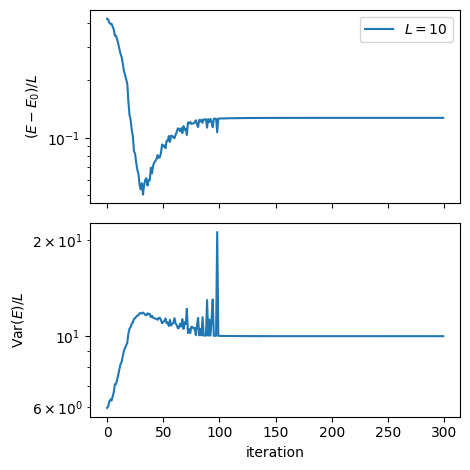

In [9]:
res = np.array(res)

fig, ax = plt.subplots(2,1, sharex=True, figsize=[4.8,4.8])
ax[0].semilogy(res[:, 0], res[:, 1] - exact_energy, '-', label=r"$L="+str(L)+"$")
ax[0].set_ylabel(r'$(E-E_0)/L$')

ax[1].semilogy(res[:, 0], res[:, 2], '-')
ax[1].set_ylabel(r'Var$(E)/L$')
ax[0].legend()
plt.xlabel('iteration')
plt.tight_layout()
plt.savefig('gs_search.pdf')